In [72]:
from functools import partial

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import statsmodels.api as sm

from ISLP import (load_data, confusion_table)
from ISLP.models import (ModelSpec as MS, summarize, poly, sklearn_sm)

from sklearn.model_selection import (train_test_split, LeaveOneOut, cross_validate, KFold, ShuffleSplit)
from sklearn.base import clone
from sklearn.metrics import mean_squared_error as mse
from sklearn.utils import resample

In [2]:
rng = np.random. default_rng(1)

### Logistic regression model with Default data set

In [3]:
Default = load_data('Default')
Default.head()

,default,student,balance,income
0,No,No,729.526495,44361.625074
1,No,Yes,817.180407,12106.134700
2,No,No,1073.549164,31767.138947
3,No,No,529.250605,35704.493935
4,No,No,785.655883,38463.495879


In [4]:
Default['default'].unique()

['No', 'Yes']
Categories (2, object): ['No', 'Yes']

In [5]:
Default.dtypes

default    category
student    category
balance     float64
income      float64
dtype: object

In [6]:
ms1 = MS(['income', 'balance'])
X = ms1.fit_transform(Default)
y = Default['default'] == 'Yes'

In [7]:
y.head()

0    False
1    False
2    False
3    False
4    False
Name: default, dtype: bool

In [8]:
glm1 = sm.GLM(y, X, family=sm.families.Binomial())
results1 = glm1.fit()
summarize(results1)

,coef,std err,z,P>|z|
intercept,-11.540500,0.435000,-26.544,0.0
income,0.000021,0.000005,4.174,0.0
balance,0.005600,0.000000,24.835,0.0


### Validation set approach

Split data into training and validation set.

In [9]:
Default_train, Default_valid = train_test_split(Default, test_size=.2, random_state=1)
Default_train.shape, Default_valid.shape

((8000, 4), (2000, 4))

In [10]:
ms2 = MS(['income', 'balance'])
X_train = ms2.fit_transform(Default_train)
y_train = Default_train['default'] == 'Yes'
glm2 = sm.GLM(y_train, X_train, family=sm.families.Binomial())
results2 = glm2.fit()
summarize(results2)

,coef,std err,z,P>|z|
intercept,-12.060600,0.507000,-23.793,0.0
income,0.000024,0.000006,4.257,0.0
balance,0.005900,0.000000,22.329,0.0


In [11]:
X_valid = ms2.fit_transform(Default_valid)
y_valid = Default_valid['default'] == 'Yes'
y_valid_ = results2.predict(X_valid)
y_valid_

9953    0.000813
3850    0.008082
4962    0.000732
3886    0.002791
5437    0.087643
          ...   
3919    0.028626
162     0.006463
7903    0.033496
2242    0.006310
2745    0.004214
Length: 2000, dtype: float64

In [12]:
L_train, L_valid = Default_train['default'], Default_valid['default']
L_train.shape, L_valid.shape

((8000,), (2000,))

In [13]:
L_valid_ = np.array(['Yes'] * Default_valid.shape[0])
L_valid_[y_valid_<.5] = 'No'
confusion_table(L_valid, L_valid_)

Truth,No,Yes
Predicted,,
No,1928,13
Yes,41,18


In [14]:
np.mean(L_valid_ == L_valid), np.mean(L_valid_ != L_valid)

(0.973, 0.027)

In [15]:
ms3 = MS(['income', 'balance', 'student'])
X_train = ms3.fit_transform(Default_train)
X_train.head()

,intercept,income,balance,student[Yes]
2694,1.0,31318.296026,1804.036475,0.0
5140,1.0,35533.484519,1174.194909,0.0
2568,1.0,25742.119731,978.652180,0.0
3671,1.0,19501.341068,548.136289,1.0
7427,1.0,36833.645138,270.072593,0.0


In [16]:
glm3 = sm.GLM(y_train, X_train, family=sm.families.Binomial())
results3 = glm3.fit()
summarize(results3)

,coef,std err,z,P>|z|
intercept,-11.418000,0.572000,-19.977,0.000
income,0.000007,0.000009,0.794,0.427
balance,0.006000,0.000000,22.274,0.000
student[Yes],-0.610000,0.267000,-2.286,0.022


In [17]:
X_valid = ms3.fit_transform(Default_valid)
y_valid = Default_valid['default'] == 'Yes'
y_valid_ = results3.predict(X_valid)
y_valid_

9953    0.000702
3850    0.007044
4962    0.000841
3886    0.002301
5437    0.079754
          ...   
3919    0.032297
162     0.005894
7903    0.029583
2242    0.005545
2745    0.003844
Length: 2000, dtype: float64

In [18]:
L_valid_ = np.array(['Yes'] * Default_valid.shape[0])
L_valid_[y_valid_<=.5] = 'No'
confusion_table(L_valid, L_valid_)

Truth,No,Yes
Predicted,,
No,1930,11
Yes,41,18


There is no significant improvement when `student` is added.

In [19]:
np.mean(L_valid_ == L_valid), np.mean(L_valid_ != L_valid)

(0.974, 0.026)

### Bootstrap function

In [20]:
def boot_fn(Default, index):
    ms = MS(['income', 'balance'])
    X = ms.fit_transform(Default.loc[index])
    y = Default.loc[index, 'default'] == 'Yes'

    results = sm.GLM(y, X, family=sm.families.Binomial()).fit()
    return results.params

In [21]:
boot_fn(Default, rng.choice(Default.index, 1000, replace=True))

intercept   -10.192116
income        0.000003
balance       0.005082
dtype: float64

In [22]:
def boot_SE(func, df, n=None, B=10, seed=1):
    rng = np.random.default_rng(seed)
    first_, second_ = 0, 0
    n = n or df.shape[0]

    for _ in range(B):
        i = rng.choice(df.index, n, replace=True)
        value = func(df, i)
        first_ += value
        second_ += value**2

    return np.sqrt(second_ / B - (first_ / B)**2)

Estimating the standard error of coefficient estimates for `income` and `balance`

In [23]:
boot_SE(boot_fn, Default, B=10, seed=1)

intercept    0.437427
income       0.000006
balance      0.000200
dtype: float64

Using a bigger value for `B` such as `100` can be slow, but using a small value like `10` is usually good enough.

### LOOCV

In [24]:
Weekly = load_data('Weekly')
Weekly.head()

,Year,Lag1,Lag2,Lag3,Lag4,Lag5,Volume,Today,Direction
0,1990,0.816,1.572,-3.936,-0.229,-3.484,0.154976,-0.270,Down
1,1990,-0.270,0.816,1.572,-3.936,-0.229,0.148574,-2.576,Down
2,1990,-2.576,-0.270,0.816,1.572,-3.936,0.159837,3.514,Up
3,1990,3.514,-2.576,-0.270,0.816,1.572,0.161630,0.712,Up
4,1990,0.712,3.514,-2.576,-0.270,0.816,0.153728,1.178,Up


In [25]:
ms1 = MS(['Lag1', 'Lag2'])
X = ms1.fit_transform(Weekly)
y = Weekly['Direction'] == 'Up'

In [26]:
X.head()

,intercept,Lag1,Lag2
0,1.0,0.816,1.572
1,1.0,-0.270,0.816
2,1.0,-2.576,-0.270
3,1.0,3.514,-2.576
4,1.0,0.712,3.514


In [27]:
y.head()

0    False
1    False
2     True
3     True
4     True
Name: Direction, dtype: bool

In [28]:
glm1 = sm.GLM(y, X, family=sm.families.Binomial())
results1 = glm1.fit()
summarize(results1)

,coef,std err,z,P>|z|
intercept,0.2212,0.061,3.599,0.000
Lag1,-0.0387,0.026,-1.477,0.140
Lag2,0.0602,0.027,2.270,0.023


Leaving the first observation out

In [29]:
glm2 = sm.GLM(y.iloc[1:], X.iloc[1:], family=sm.families.Binomial())
results2 = glm2.fit()
summarize(results2)

,coef,std err,z,P>|z|
intercept,0.2232,0.061,3.630,0.000
Lag1,-0.0384,0.026,-1.466,0.143
Lag2,0.0608,0.027,2.291,0.022


In [30]:
prob = results2.predict(X.iloc[0:1])
prob

0    0.571392
dtype: float64

It seems the first observation was incorrectly classified.

In [31]:
def up_down(is_up):
    return 'Up' if is_up else 'Down'

In [32]:
up_down(prob[0] > .5), up_down(y[0])

('Up', 'Down')

In [33]:
X.shape

(1089, 3)

In [34]:
X.loc[X.index.isin([1])]

,intercept,Lag1,Lag2
1,1.0,-0.27,0.816


In [35]:
np.zeros(10)

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [36]:
n = X.shape[0]
misclassified = np.zeros(n)

for i in range(0, n):
    print('.', end='')
    # exclude ith index
    idx = X.index.isin([i])
    glm = sm.GLM(y.loc[~idx], X.loc[~idx], family=sm.families.Binomial())
    results = glm.fit()
    prob = results.predict(X.loc[idx])

    misclassified[i] = up_down(prob[i] > .5) == up_down(y[i])

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

In [37]:
np.mean(misclassified) * 100

55.00459136822773

The error rate is 55%, which is worst than random guessing!

### Cross-validation on simulated data

In [38]:
rng = np.random.default_rng(1)
n = 100
x = rng.normal(size=n)
y = x - 2 * x**2 + rng.normal(size=n)

Sim = pd.DataFrame({'x': x, 'y': y})
Sim.head()

,x,y
0,0.345584,-0.544554
1,0.821618,0.333950
2,0.330437,-0.013532
3,-1.303157,-4.030442
4,0.905356,0.484861


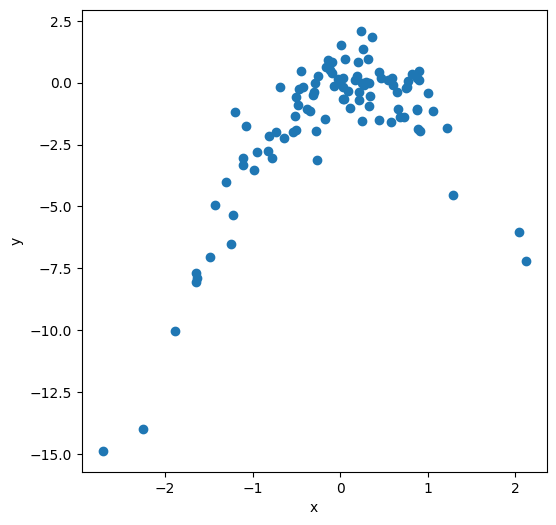

In [39]:
_, ax = plt.subplots(figsize=(6, 6))
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.scatter(x, y);

The data shows a non-linear pattern.

In [40]:
# random index from Sim data
# Sim.loc[rng.choice(Sim.index, 1)]

We use [sklearn_sm](https://islp.readthedocs.io/en/latest/api/generated/ISLP.models.sklearn_wrap.html#ISLP.models.sklearn_wrap.sklearn_sm.score) to wrap `sm.OLS`. As per `sklearn_sm`, the [score](https://github.com/intro-stat-learning/ISLP/blob/main/ISLP/models/sklearn_wrap.py#L116) method uses MSE scoring.

In [50]:
cv_error = np.zeros(4)
x = np.array(Sim['x'])

# wraps sm.OLS for sklearn, scoring uses MSE.
sk_ols = sklearn_sm(sm.OLS)
y = Sim['y']

for i, degree in enumerate(range(1, 5)):
    # add polynomial degree
    X = np.power.outer(x, np.arange(degree+1))
    score = cross_validate(sk_ols, X, y, cv=Sim.shape[0])
    # take the mean of all scores
    cv_error[i] = np.mean(score['test_score'])

cv_error

array([6.63302984, 1.12293686, 1.30179655, 1.33239427])

In [42]:
rng = np.random.default_rng(3)
n = 100
x = rng.normal(size=n)
y = x - 2 * x**2 + rng.normal(size=n)

Sim2 = pd.DataFrame({'x': x, 'y': y})
Sim2.head()

,x,y
0,2.040919,-6.606938
1,-2.555665,-15.325279
2,0.418099,-0.174850
3,-0.567770,-0.395288
4,-0.452649,-1.656879


In [49]:
cv_error = np.zeros(8)
x = np.array(Sim2['x'])
sk_ols = sklearn_sm(sm.OLS)
y = Sim2['y']

cv_error = np.zeros(4)
for i, degree in enumerate(range(1, 5)):
    # add polynomial degree
    X = np.power.outer(x, np.arange(degree+1))
    score = cross_validate(sk_ols, X, y, cv=Sim.shape[0])
    cv_error[i] = np.mean(score['test_score'])

cv_error

array([14.55880836,  1.04488356,  0.9342266 ,  0.94655557])

As can be seen above, adding cubic term provides a substatial improvement on the score, tho, higher degrees don't provide significant improvement.

### Bootstrap estimates

In [51]:
Boston = load_data('Boston')
Boston.head()

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,lstat,medv
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,5.33,36.2


In [57]:
Boston.shape

(506, 13)

#### Mean estimate

Sample mean and standard deviation of `medv`, $\hat \mu$

In [61]:
Boston['medv'].mean(), Boston['medv'].std()

(22.532806324110677, 9.197104087379818)

Standard error of the sample mean.

$
SE{\hat \mu} = \frac{s}{\sqrt{n}}
$

In [62]:
Boston['medv'].std()/Boston.shape[0]**.5, Boston['medv'].sem()

(0.40886114749753505, 0.40886114749753505)

In [66]:
Boston['medv'].loc[:]

0      24.0
1      21.6
2      34.7
3      33.4
4      36.2
       ... 
501    22.4
502    20.6
503    23.9
504    22.0
505    11.9
Name: medv, Length: 506, dtype: float64

In [123]:
boot_SE(mu_func2, Boston['medv'], B=1000, seed=1)

0.4153379484779142

In [128]:
def mu_func(df):
    return df.mean()

def mu_func2(df, idx):
    return df.loc[idx].mean()
    
def boot_SE2(func, df, n=None, B=1000, seed=1):
    rng = np.random.RandomState(seed)
    first_, second_ = 0, 0
    n = n or df.shape[0]

    for _ in range(B):
        sample = resample(df, n_samples=n, random_state=rng)
        value = func(sample)
        first_ += value
        second_ += value**2

    return np.sqrt(second_ / B - (first_ / B)**2)

def resample_SE(func, df, n=None, B=1000, seed=1):
    rng = np.random.RandomState(seed)
    n = n or df.shape[0]

    ests = []
    
    for _ in range(B):
        sample = resample(df, n_samples=n, random_state=rng)
        est = func(sample)
        ests.append(est)

    # Convert to array for numerical operations
    # estimates = np.array(estimates)
    mean_est = np.mean(ests)
    sqrd_err = np.sum((ests - mean_est)**2)
    
    # Standard error = std deviation of bootstrap estimates
    return np.sqrt(sqrd_err / (B - 1))

Bootstrap estimates are 0.01 higher than the original estimates.

In [136]:
resample_SE(mu_func, Boston['medv'], B=1000)

0.41260905740250564

In [133]:
boot_SE2(mu_func, Boston['medv'], B=1000)

0.4124027012694416

95% confidence interval mean estimates.

$[{\hat \mu} - 2SE({\hat \mu}), {\hat \mu} + 2SE({\hat \mu})]$

In [153]:
y = Boston['medv']
mu_hat = y.mean()
mu_hat_se = resample_SE(mu_func, y, B=1000)
mu_hat, mu_hat_se

(22.532806324110677, 0.41260905740250564)

In [152]:
mu_hat - 2*mu_hat_se, mu_hat + 2*mu_hat_se

(21.707588209305666, 23.358024438915688)

#### Median estimates

In [140]:
def median_func(df):
    return df.median()

Median and median estimate SE

In [155]:
mu_hat_med = y.median()
mu_hat_med_se = resample_SE(median_func, y, B=100)

mu_hat_med, mu_hat_med_se

(21.2, 0.3758169552300473)

95% confidence interval of estimates.

In [156]:
mu_hat_med - 2*mu_hat_med_se, mu_hat_med + 2*mu_hat_med_se

(20.448366089539906, 21.951633910460092)

#### 10th percentile estimates

In [157]:
def pct_func(df):
    return np.percentile(df, q=10)

In [158]:
pct_hat = np.percentile(y, q=10)
pct_hat_se = resample_SE(pct_func, y, B=1000)
pct_hat, pct_hat_se

(12.75, 0.4886077952484769)

95% confidence interval of estimate.

In [159]:
pct_hat - 2*pct_hat_se, pct_hat + 2*pct_hat_se

(11.772784409503046, 13.727215590496954)